[SGD] Epoch 1, Loss: 0.1357
[SGD] Epoch 2, Loss: 0.0914
[SGD] Epoch 3, Loss: 0.0848
[SGD] Epoch 4, Loss: 0.0667
[SGD] Epoch 5, Loss: 0.0558
[SGD] Epoch 6, Loss: 0.0489
[SGD] Epoch 7, Loss: 0.0454
[SGD] Epoch 8, Loss: 0.0430
[SGD] Epoch 9, Loss: 0.0409
[SGD] Epoch 10, Loss: 0.0390
[SGD] Epoch 11, Loss: 0.0375
[SGD] Epoch 12, Loss: 0.0362
[SGD] Epoch 13, Loss: 0.0352
[SGD] Epoch 14, Loss: 0.0343
[SGD] Epoch 15, Loss: 0.0333
[SGD] Epoch 16, Loss: 0.0323
[SGD] Epoch 17, Loss: 0.0312
[SGD] Epoch 18, Loss: 0.0302
[SGD] Epoch 19, Loss: 0.0294
[SGD] Epoch 20, Loss: 0.0288
[SGD] Epoch 21, Loss: 0.0283
[SGD] Epoch 22, Loss: 0.0279
[SGD] Epoch 23, Loss: 0.0275
[SGD] Epoch 24, Loss: 0.0272
[SGD] Epoch 25, Loss: 0.0269
[SGD] Epoch 26, Loss: 0.0266
[SGD] Epoch 27, Loss: 0.0263
[SGD] Epoch 28, Loss: 0.0261
[SGD] Epoch 29, Loss: 0.0258
[SGD] Epoch 30, Loss: 0.0256
[SGD] Epoch 31, Loss: 0.0253
[SGD] Epoch 32, Loss: 0.0251
[SGD] Epoch 33, Loss: 0.0249
[SGD] Epoch 34, Loss: 0.0247
[SGD] Epoch 35, Loss: 0

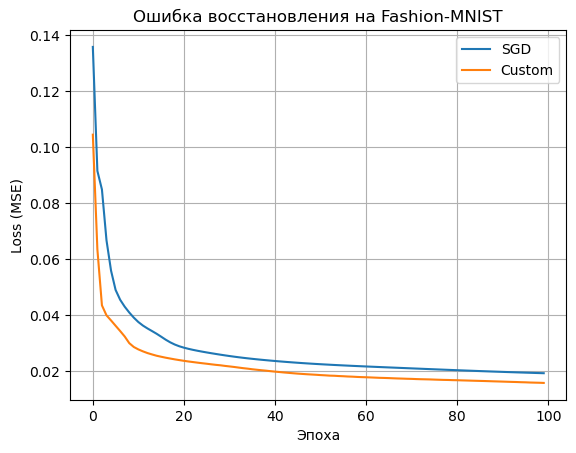

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

latent_dim = 16
batch_size = 32
max_epochs = 100
lr = 0.1
patience = 3
min_delta = 0.001
lr_decay_factor = 0.5
lr_min = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class CustomOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            eta = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if len(p.data.shape) == 2:
                    update = grad + grad @ p.data.T @ p.data
                else:
                    update = grad
                p.data = p.data - eta * update
        return loss

def train(model, optimizer, name):
    model.train()
    losses = []
    criterion = nn.MSELoss()
    prev_loss = None
    stable_epochs = 0

    for epoch in range(max_epochs):
        epoch_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * x.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f"[{name}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if prev_loss is not None and abs(prev_loss - avg_loss) / prev_loss < min_delta:
            stable_epochs += 1
        else:
            stable_epochs = 0

        if stable_epochs >= 1:
            # Понижаем learning rate
            for group in optimizer.param_groups:
                old_lr = group['lr']
                new_lr = max(old_lr * lr_decay_factor, lr_min)
                if new_lr < old_lr:
                    print(f"[{name}] Понижение learning rate: {old_lr:.5f} -> {new_lr:.5f}")
                    group['lr'] = new_lr
        if stable_epochs >= patience:
            break
        prev_loss = avg_loss
    return losses

model_sgd = Autoencoder(latent_dim).to(device)
model_custom = Autoencoder(latent_dim).to(device)

optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr)
optimizer_custom = CustomOptimizer(model_custom.parameters(), lr=lr)

losses_sgd = train(model_sgd, optimizer_sgd, "SGD")
losses_custom = train(model_custom, optimizer_custom, "Custom")

plt.plot(losses_sgd, label="SGD")
plt.plot(losses_custom, label="Custom")
plt.xlabel("Эпоха")
plt.ylabel("Loss (MSE)")
plt.title("Ошибка восстановления на Fashion-MNIST")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from skimage.metrics import structural_similarity as ssim

test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

def compute_ssim(model):
    model.eval()
    total_ssim = 0
    count = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon = model(x)
            x_np = x.cpu().numpy()
            x_recon_np = x_recon.cpu().numpy()
            for i in range(x.size(0)):
                img1 = x_np[i, 0]
                img2 = x_recon_np[i, 0]
                total_ssim += ssim(img1, img2, data_range=1.0)
            count += x.size(0)
    return total_ssim / count

ssim_sgd = compute_ssim(model_sgd)
ssim_custom = compute_ssim(model_custom)

print(f"SSIM (SGD):    {ssim_sgd:.4f}")
print(f"SSIM (Custom): {ssim_custom:.4f}")


SSIM (SGD):    0.6020
SSIM (Custom): 0.6555


In [5]:
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

def compute_metrics(model):
    model.eval()
    total_ssim = 0
    total_mse = 0
    count = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon = model(x)
            
            x_np = x.cpu().numpy()
            x_recon_np = x_recon.cpu().numpy()
            for i in range(x.size(0)):
                img1 = x_np[i, 0]
                img2 = x_recon_np[i, 0]
                total_ssim += ssim(img1, img2, data_range=1.0)
            
            total_mse += F.mse_loss(x_recon, x, reduction='sum').item()
            count += x.size(0)
    
    avg_ssim = total_ssim / count
    avg_mse = total_mse / count
    return avg_ssim, avg_mse

ssim_sgd, mse_sgd = compute_metrics(model_sgd)
ssim_custom, mse_custom = compute_metrics(model_custom)

print(f"SSIM (SGD):    {ssim_sgd:.4f} | MSE (SGD):    {mse_sgd:.6f}")
print(f"SSIM (Custom): {ssim_custom:.4f} | MSE (Custom): {mse_custom:.6f}")


SSIM (SGD):    0.6020 | MSE (SGD):    15.078319
SSIM (Custom): 0.6555 | MSE (Custom): 12.337030


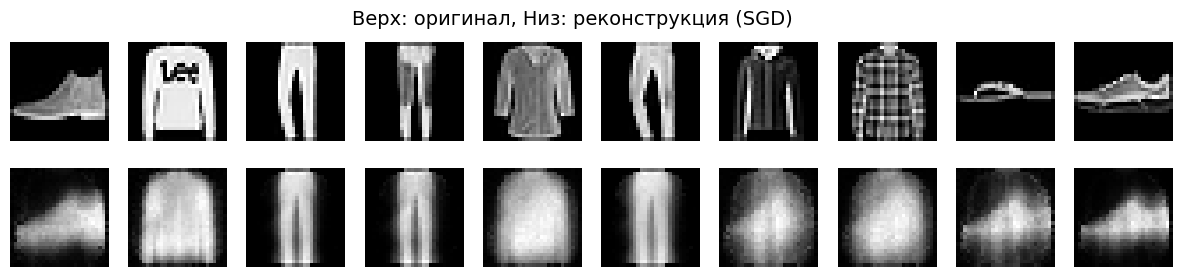

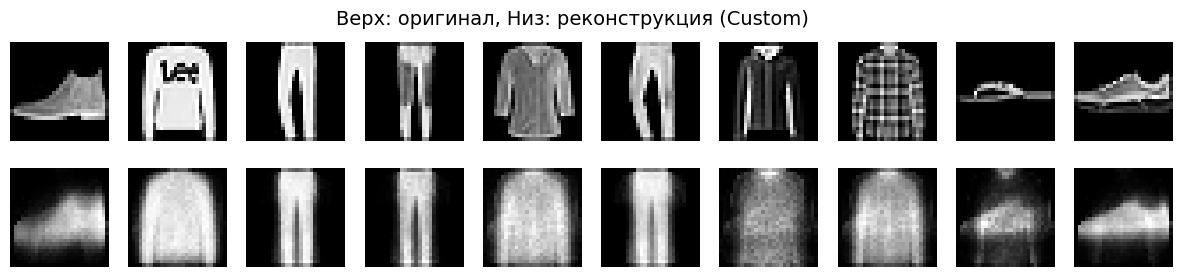

In [8]:
def show_reconstructions(model, name):
    model.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_recon = model(x)
            break

    x = x.cpu().numpy()
    x_recon = x_recon.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(x[i, 0], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(x_recon[i, 0], cmap="gray")
        axes[1, i].axis("off")
    fig.suptitle(f"Верх: оригинал, Низ: реконструкция ({name})", fontsize=14)
    plt.show()

show_reconstructions(model_sgd, "SGD")
show_reconstructions(model_custom, "Custom")
